In [ ]:
import glob
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

# Load Data

In [20]:
files = []
files.extend(glob.glob('data/unidirectional/*.csv'))
files.extend(glob.glob('data/bidirectional/*.csv'))

print(f"Loaded {len(files)} files")

Loaded 36 files


In [65]:
combined = pd.DataFrame(columns=["Participant","Condition","Response","Test Stim","Test Speed","Correct","Time"])
subjects = set()

for file in files:
    name = file[file.rfind('/')+1:][:3]
    subjects.add(name)

    match file:
        case file if 'unidirectional' in file:
            t_type = 'Unidirectional Adapt'
        case file if 'bidirectional' in file and 'noAdapt' not in file:
            t_type = 'Bidirectional Adapt'
        case _:
            t_type = 'No Adapt'

    participant_data = pd.read_csv(file, index_col=0)
    participant_data["Participant"] = name
    participant_data["Condition"] = t_type
    combined = pd.concat([combined, participant_data], axis=0)

subject_list = sorted(list(subjects))
combined.to_csv("./data/combined.csv")
combined.head()

/var/folders/38/cyy5p2n96d1fr3wzqvg05w4c0000gn/T/ipykernel_41218/1999358396.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([combined, participant_data], axis=0)


,Participant,Condition,Response,Test Stim,Test Speed,Correct,Time
0,nxn,Unidirectional Adapt,right,log,38.0,True,0.941106
1,nxn,Unidirectional Adapt,right,mirror,62.0,True,1.054182
2,nxn,Unidirectional Adapt,right,mirror,62.0,True,1.238950
3,nxn,Unidirectional Adapt,left,log,70.0,False,2.613170
4,nxn,Unidirectional Adapt,right,mirror,70.0,True,0.793902


In [59]:
# Subjects that adapted to CCW tested speeds [-70, 10] in the unidirectional condition.
# This is manually checked by looking at the unidirectional data.
dirmap = {
    "ccw": ["jdg", "nst", "nxs", "mxw", "tee", "ksm"],
    "cw": ["anb", "kxt", "mjl", "nxn", "sxk", "txd"],
}

# Psychometric Function Fitting

In [ ]:
# This is fitting Gaussian CDF (mu and sigma) with floor and ceiling parameters
def f(x, m, s, a, b):
    return a + (b - a) * norm.cdf(x, m, s)

In [60]:
output = pd.DataFrame(columns=['Name', 'Exp Type', 'Adapt Direction', 'Mu', 'Sigma', 'Floor', 'Ceiling', 'R^2'])

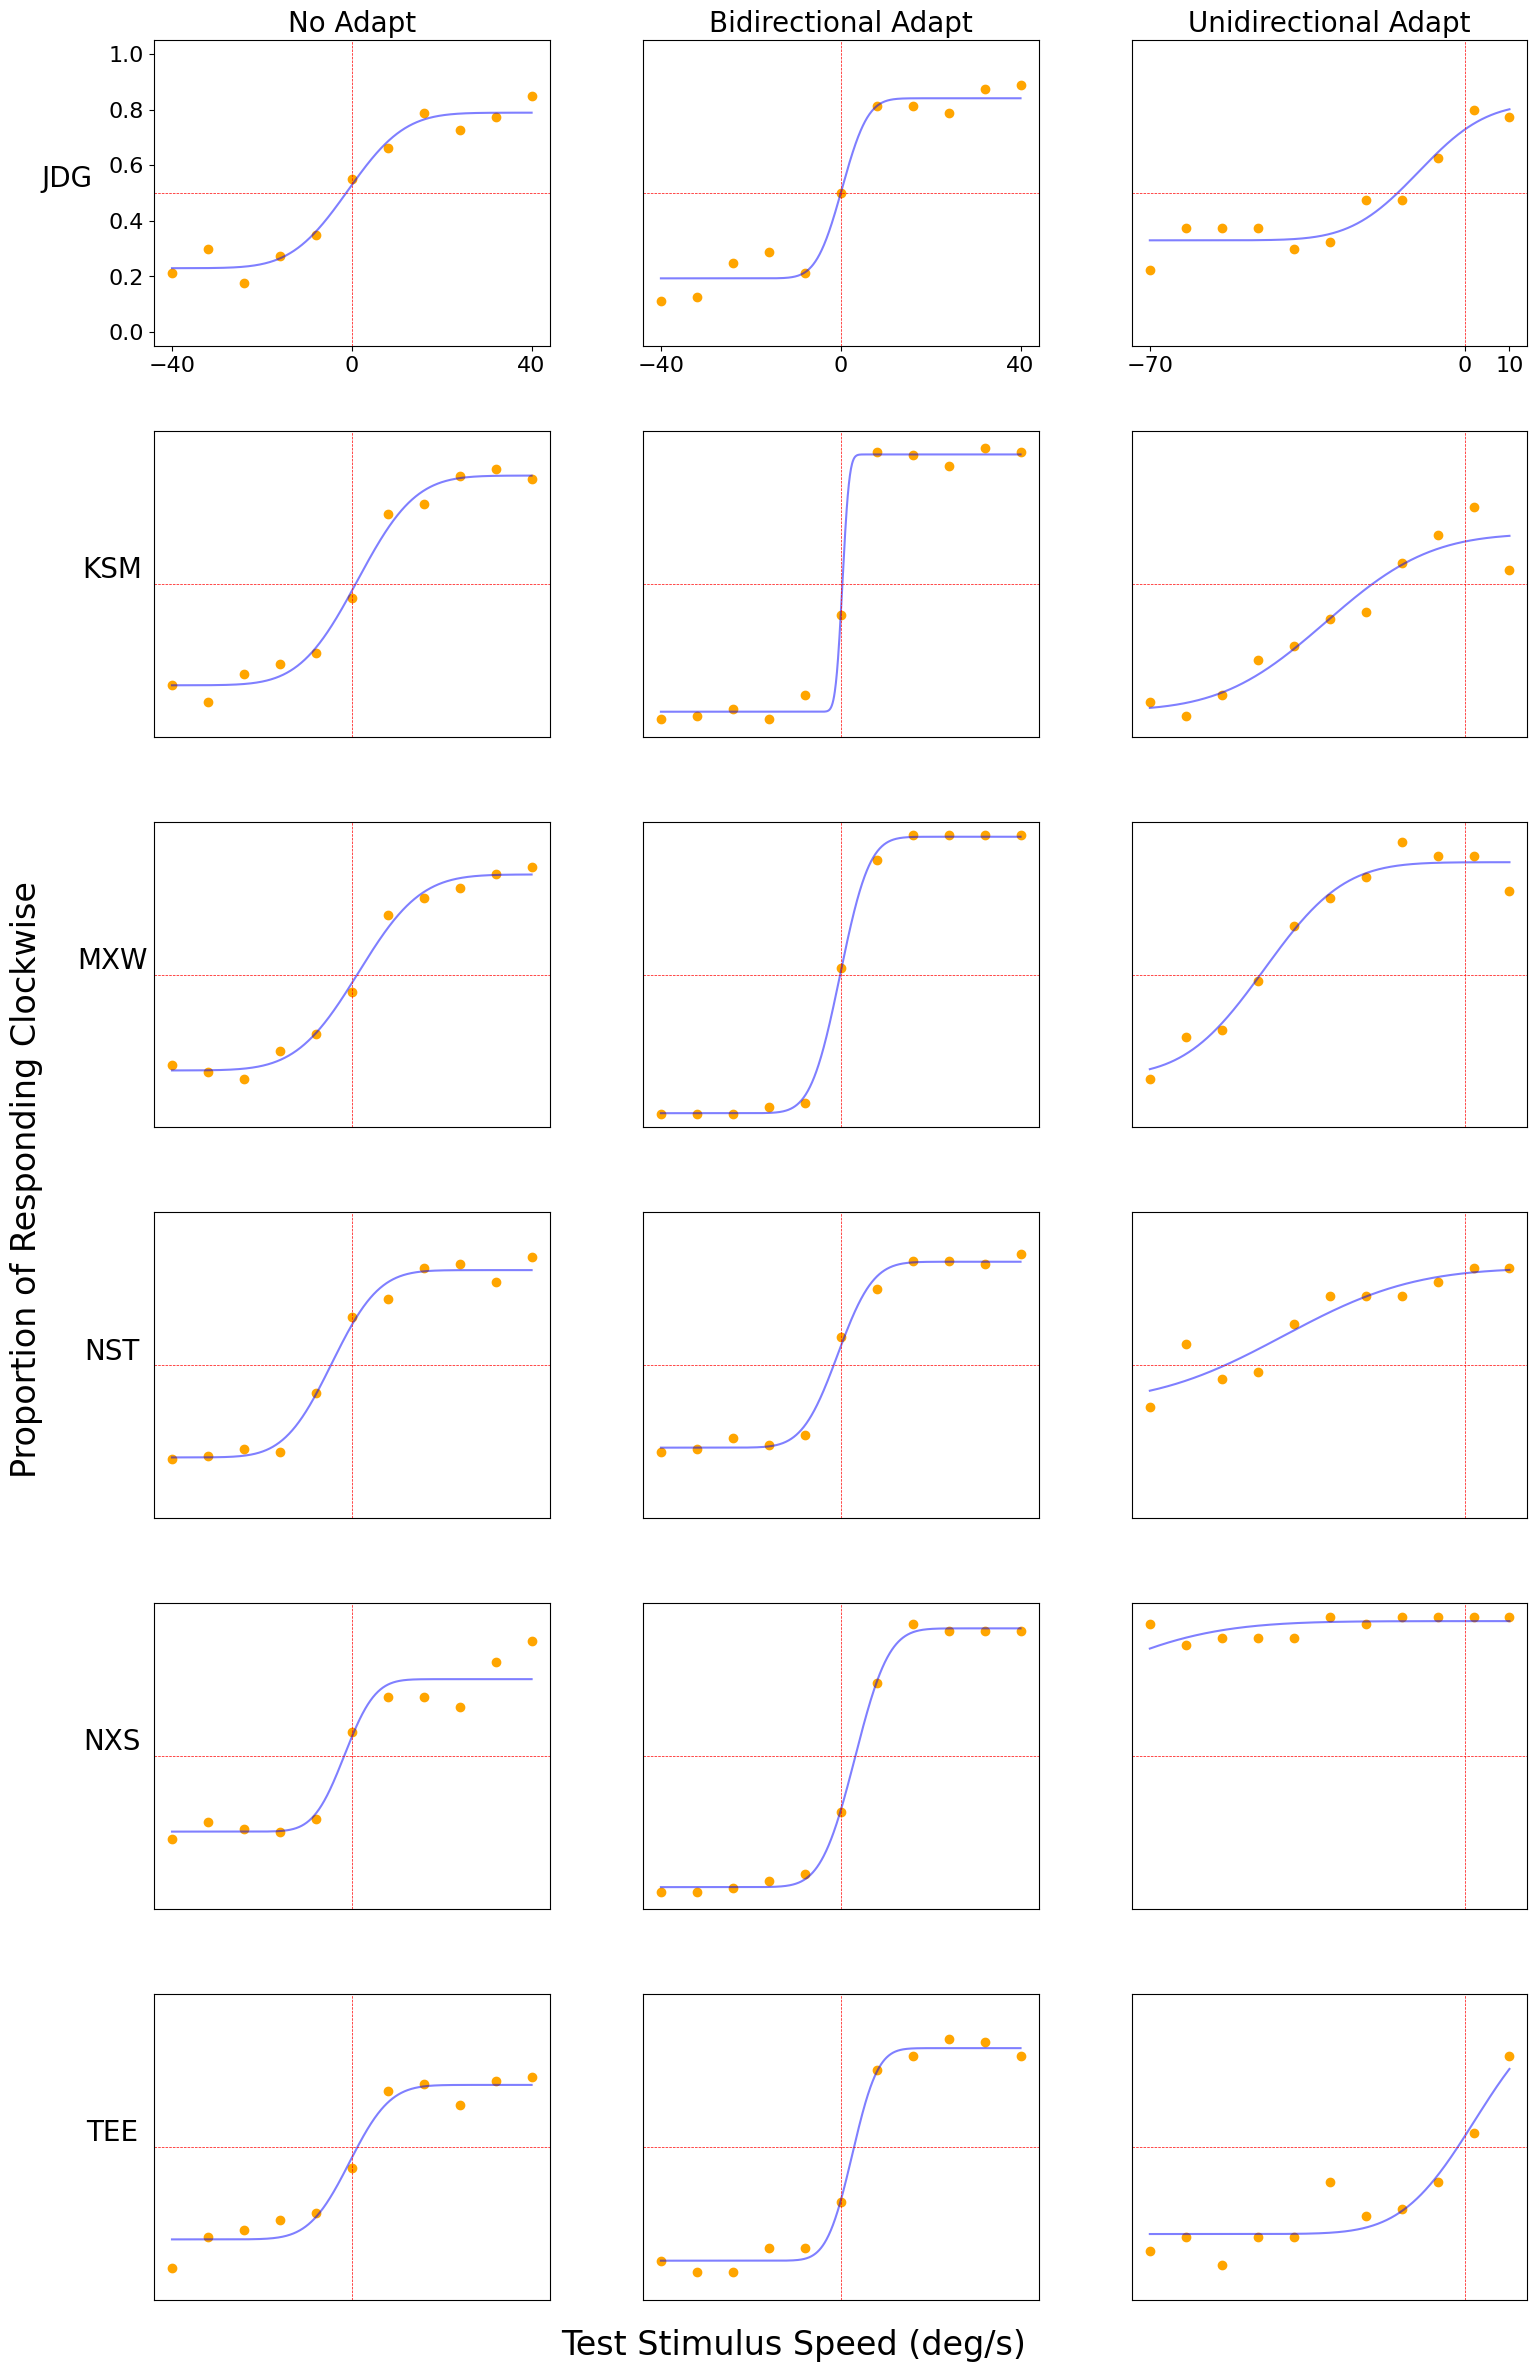

In [ ]:
PLOT_TYPE = "ccw"

NROWS = 6
NCOLS = 3

fig, ax = plt.subplots(NROWS, NCOLS, figsize=(16,24))
fig.text(0.5, 0.01, 'Test Stimulus Speed (deg/s)', ha='center', fontsize=24)
fig.text(0.01, 0.5, 'Proportion of Responding Clockwise', va='center', rotation='vertical', fontsize=24)
fig.tight_layout(pad=4.0)


for r, subject in enumerate(sorted(dirmap[PLOT_TYPE])):
    for c, condition in enumerate(["No Adapt", "Bidirectional Adapt", "Unidirectional Adapt"]):
        data = combined[(combined["Participant"] == subject) & (combined["Condition"] == condition)]

        responses = data.groupby('Test Speed')['Response']
        count_data = responses.apply(lambda x: x[x.str.contains('right')].count())
        total_counts = responses.count()
        speeds = count_data.index.tolist()

        cw_counts = count_data.tolist()
        cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
        (mu, sigma, a, b), _ = curve_fit(
            f,
            speeds,
            cw_proportions,
            method='dogbox',
            p0=[0, 3, 0, 1],
            bounds=([-90, 0, 0, 0.5], [90, 90, 0.5, 1]),
        )

        pred = f(speeds, mu, sigma, a, b)
        r2 = r2_score(cw_proportions, pred)

        ax[r, c].scatter(speeds, cw_proportions, color='orange', label='Subject Data')

        t = np.linspace(min(speeds), max(speeds), 1000)
        ax[r, c].plot(t, f(t, mu, sigma, a, b), alpha=.5, color='blue', label='Guassian Fit')

        ax[r, c].axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed')
        ax[r, c].axvline(x=0, color='r', linewidth=0.5, linestyle='dashed')
        ax[r, c].set_ylim(-0.05, 1.05)

        ax[r, c].tick_params(axis='both', which='both', labelsize=16)
        if r == 0:
            ax[r, c].set_title(f'{condition}', fontsize=20)
        if c == 0:
            ax[r, c].set_ylabel(f'{subject.upper()}', labelpad=30, rotation=0, fontsize=20)
        if r != 0 or c != 0:
            ax[r, c].set_yticklabels([])
            ax[r, c].set_yticks([])

        if r > 0:
            ax[r, c].set_xticklabels([])
            ax[r, c].set_xticks([])
        else:
            match condition:
                case "Unidirectional Adapt":
                    ticks = [-70, 0, 10] if PLOT_TYPE == "ccw" else [-10, 0, 70]
                    ax[r, c].set_xticks(ticks)
                case _:
                    ax[r, c].set_xticks([-40, 0, 40])

        direction = PLOT_TYPE if condition == "Unidirectional Adapt" else ''
        output.loc[len(output)] = [subject, condition, direction, mu, sigma, a, b, r2]
        handles, labels = ax[r, c].get_legend_handles_labels()

plt.subplots_adjust(left=0.1)
plt.savefig(f"./plots/psychometric_fits_{PLOT_TYPE}.svg", pad_inches=0.1)
plt.show()

In [ ]:
output.to_csv("./results/gauss_fits.csv")

# Bootstrapping Confidence Intervals

Read https://acclab.github.io/bootstrap-confidence-intervals.html for more information.

In [332]:
np.random.seed(0)

cis = pd.DataFrame(columns=['Name', 'Exp Type', 'Mu CI', 'Sigma CI'])

100%|██████████| 12/12 [02:23<00:00, 11.98s/it]


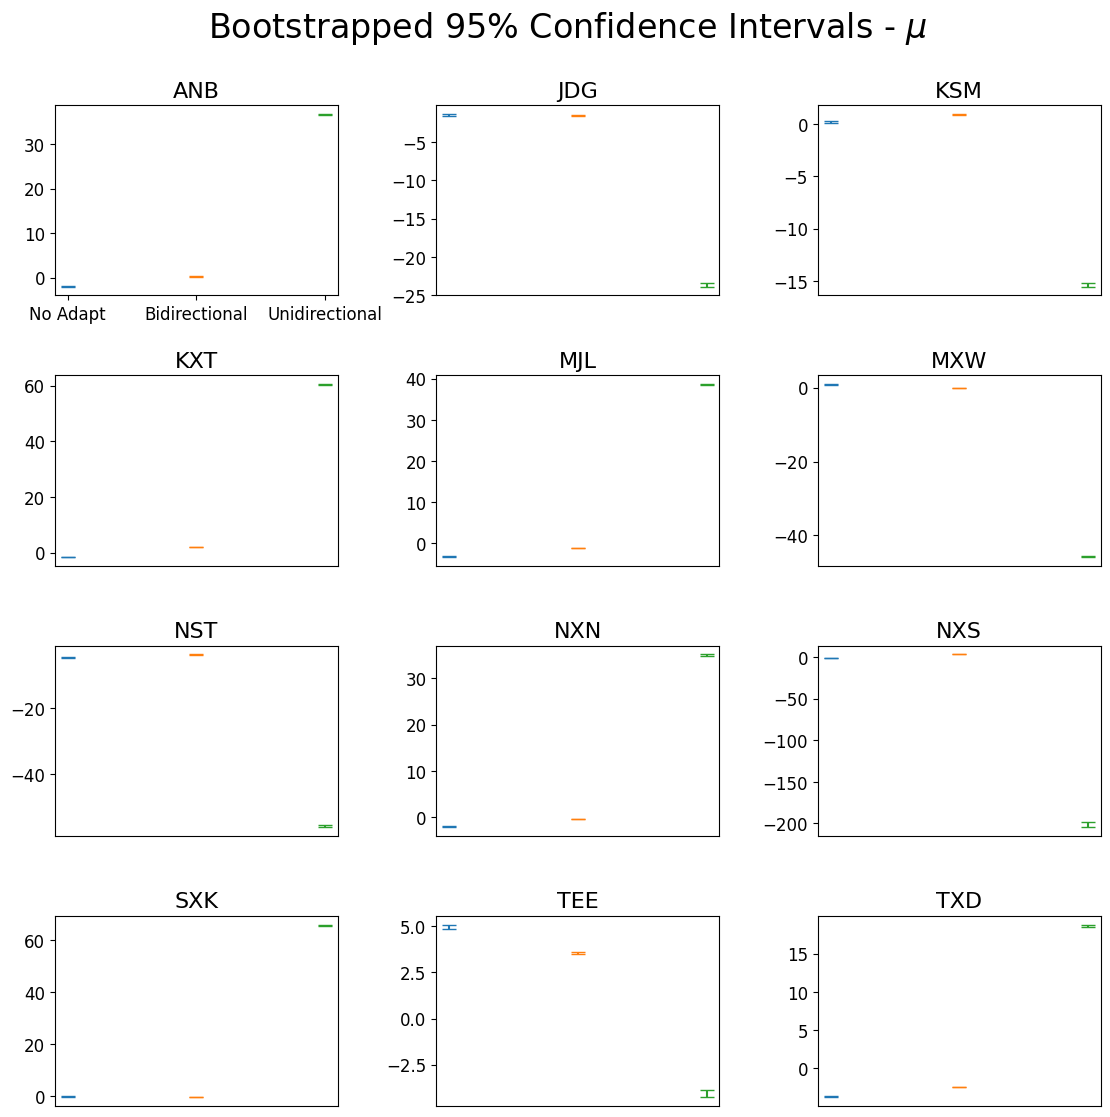

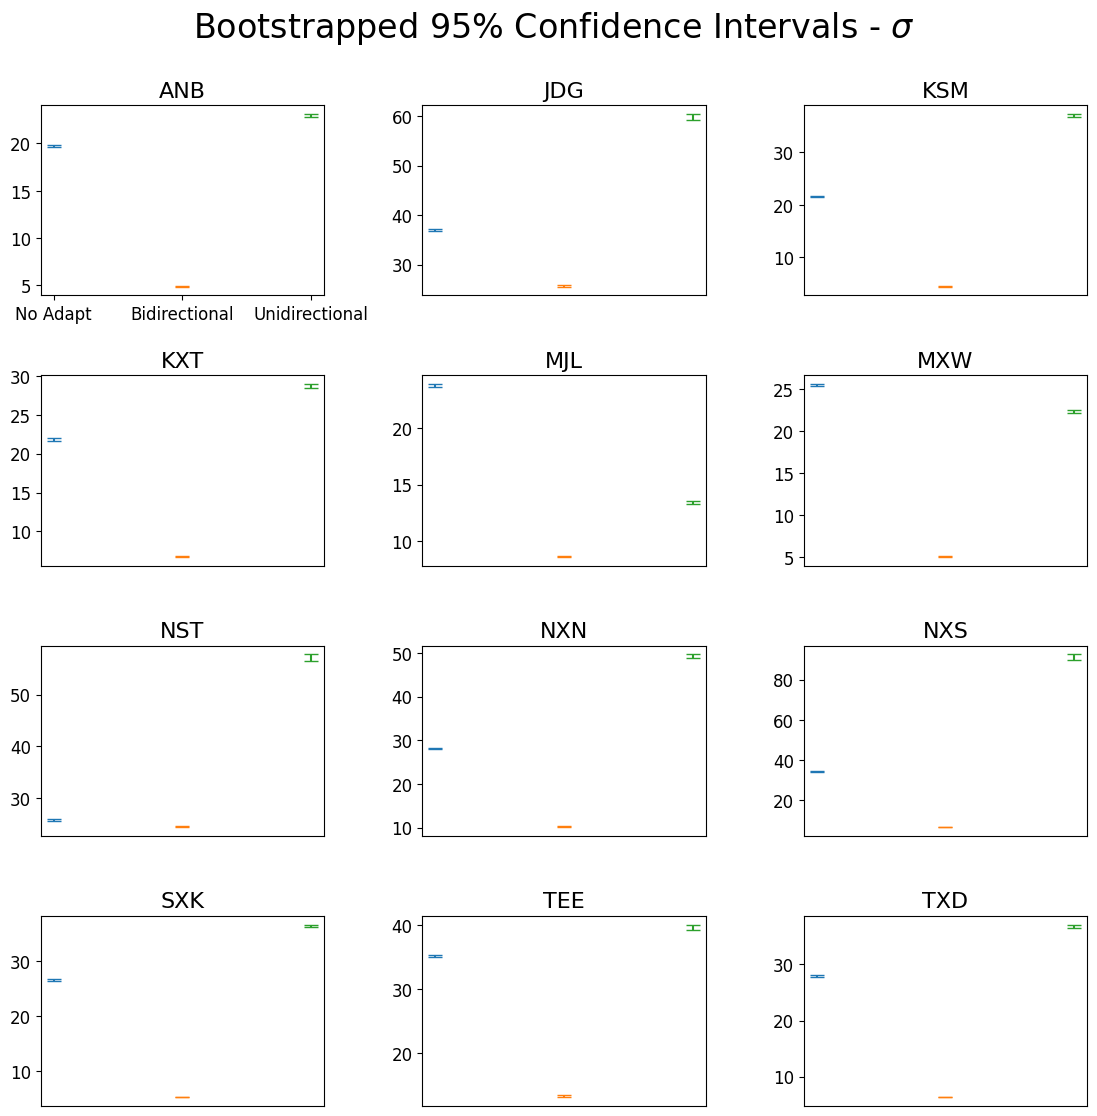

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
def confidence_interval(lst, alpha=0.95):
    return st.t.interval(
        alpha,
        df=len(lst)-1,
        loc=np.mean(lst),
        scale=st.sem(lst),
    )

def f(x, m, s):
    return norm.cdf(x, m, s)

N_SAMPLES = 1000

N_ROWS = 4
N_COLS = 3
fig_mu, ax_mu = plt.subplots(4, 3, figsize=(12, 12))
fig_mu.tight_layout(pad=4.0)
fig_mu.subplots_adjust(top=0.9)
fig_mu.suptitle("Bootstrapped 95% Confidence Intervals - $\mu$", fontsize=24)

fig_sigma, ax_sigma = plt.subplots(4, 3, figsize=(12, 12))
fig_sigma.tight_layout(pad=4.0)
fig_sigma.subplots_adjust(top=0.9)
fig_sigma.suptitle("Bootstrapped 95% Confidence Intervals - $\sigma$", fontsize=24)

for i, subject in enumerate(tqdm(subject_list)):
    plt.figure(figsize=(8, 6))
    for condition in ["No Adapt", "Bidirectional Adapt", "Unidirectional Adapt"]:
        original_data = combined[(combined["Participant"] == subject) & (combined["Condition"] == condition)]
        mus, sigmas = [], []
        for _ in range(N_SAMPLES):
            data = original_data.sample(replace=True, n=len(original_data))

            count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
            total_counts = data.groupby('Test Speed').count()['Response']
            speeds = count_data.index.tolist()

            cw_counts = count_data.tolist()
            cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
            (mu, sigma), _ = curve_fit(f, speeds, cw_proportions, method='dogbox', p0=[0, 2], maxfev=1500)

            mus.append(mu)
            sigmas.append(sigma)

        mu_ci = confidence_interval(mus)
        mu_err = (mu_ci[1] - mu_ci[0]) / 2

        sigma_ci = confidence_interval(sigmas)
        sigma_err = (sigma_ci[1] - sigma_ci[0]) / 2

        row, col = i // N_COLS, i % N_COLS

        label = condition if condition == "No Adapt" else condition.replace(" Adapt", "")
        ax_mu[row, col].tick_params(axis='both', which='both', labelsize=12)
        ax_mu[row, col].errorbar(label, np.mean(mus), yerr=mu_err, capsize=5)
        ax_mu[row, col].set_title(subject.upper(), fontsize=16)

        ax_sigma[row, col].tick_params(axis='both', which='both', labelsize=12)
        ax_sigma[row, col].errorbar(label, np.mean(sigmas), yerr=sigma_err, capsize=5)
        ax_sigma[row, col].set_title(subject.upper(), fontsize=16)

        if i > 0:
            ax_mu[row, col].set_xticklabels([])
            ax_mu[row, col].set_xticks([])
            ax_sigma[row, col].set_xticklabels([])
            ax_sigma[row, col].set_xticks([])

        cis.loc[len(cis)] = [subject, condition, mu_ci, sigma_ci]


fig_mu.savefig("./plots/ci_mu.svg")
fig_sigma.savefig("./plots/ci_sigma.svg")

In [357]:
cis.head()

,Name,Exp Type,Mu CI,Sigma CI
0,anb,No Adapt,"(-2.054, -1.909)","(19.631, 19.828)"
1,anb,Bidirectional Adapt,"(0.183, 0.261)","(4.862, 4.934)"
2,anb,Unidirectional Adapt,"(36.521, 36.777)","(22.791, 23.119)"
3,jdg,No Adapt,"(-1.568, -1.359)","(36.772, 37.166)"
4,jdg,Bidirectional Adapt,"(-1.598, -1.437)","(25.517, 25.785)"


In [ ]:
cis['Mu CI'] = cis['Mu CI'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
cis['Sigma CI'] = cis['Sigma CI'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
cis.to_csv('./results/ci_data.csv')

# Aggregated Results

In [82]:
def aggregate_data(condition, subjects=subjects):
    data = combined[(combined['Condition'] == condition) & (combined['Participant'].isin(subjects))]
    responses = data.groupby(['Test Speed', 'Participant'])['Response']
    cw_counts = responses.apply(lambda x: x[x.str.contains('right')].count())
    total_counts = responses.count()

    cw_proportions = (cw_counts / total_counts).groupby(by='Test Speed')
    return cw_proportions.mean(), cw_proportions.sem()

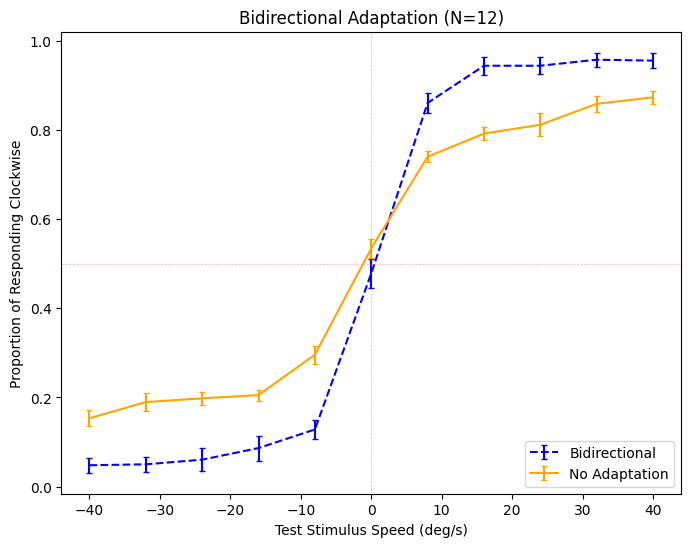

In [109]:
cw_adapt_ccw, sem_adapt_ccw = aggregate_data('Bidirectional Adapt')
cw_noadapt, sem_noadapt = aggregate_data('No Adapt')

plt.figure(figsize=(8, 6))
plt.errorbar(cw_adapt_ccw.index.tolist(), cw_adapt_ccw, yerr=sem_adapt_ccw, linestyle='dashed', label='Bidirectional', c='blue', capsize=2)
plt.errorbar(cw_noadapt.index.tolist(), cw_noadapt, yerr=sem_noadapt, label='No Adaptation', c='orange', capsize=2)

plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Bidirectional Adaptation (N={len(subjects)})')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig('./plots/average_bidirectional.svg')

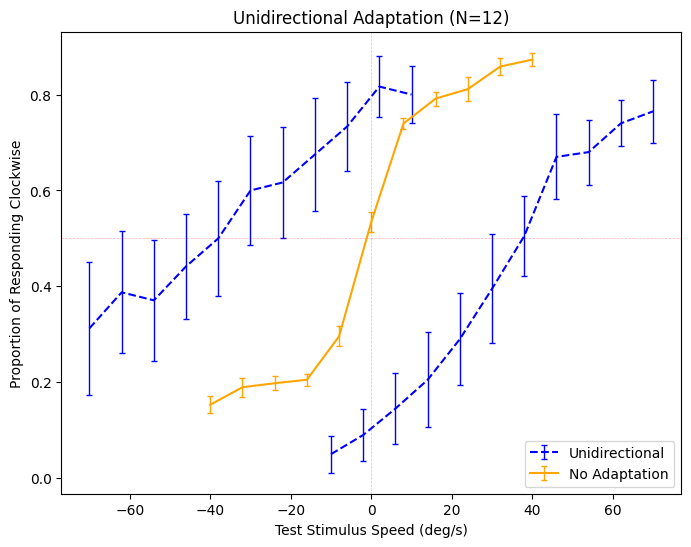

In [111]:
cw_adapt_ccw, sem_adapt_ccw = aggregate_data('Unidirectional Adapt', dirmap["ccw"])
cw_adapt_cw, sem_adapt_cw = aggregate_data('Unidirectional Adapt', [x for x in dirmap["cw"] if x != "sxk"])
cw_noadapt, sem_noadapt = aggregate_data('No Adapt')

plt.figure(figsize=(8, 6))
plt.errorbar(cw_adapt_ccw.index.tolist(), cw_adapt_ccw, yerr=sem_adapt_ccw, linestyle='dashed', label='Unidirectional', c='blue', capsize=2, elinewidth=1)
plt.errorbar(cw_adapt_cw.index.tolist(), cw_adapt_cw, yerr=sem_adapt_cw, linestyle='dashed', c='blue', capsize=2, elinewidth=1)
plt.errorbar(cw_noadapt.index.tolist(), cw_noadapt, yerr=sem_noadapt, label='No Adaptation', c='orange', capsize=2, elinewidth=1)

plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Unidirectional Adaptation (N={len(subjects)})')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig('./plots/average_unidirectional.svg')